# Working with morphologies (or `jaxley.io`)

`Jaxley` offers several toolchains to import, export, define, and work with neural morphologies specified via different data formats. All the methods we are going explore in this tutorial are contained within `jaxley.io`.

In this tutorial, you will learn how to:
- Load morphologies and make them compatible with `Jaxley` using jaxley built in `swc` parser.
- How to use `Jaxley`'s built in visualization features
- How to assemble a small network of morphologically accurate cells.
- How to use `Jaxley`s graph pipeline, which offers interoperability with `networkX`. We will:
    - define morphologies via `networkX` graphs.
    - export morphologies to `networkX` graphs.
    - import morphologies using `Jaxley`'s graph pipeline.

In [1]:
import jaxley as jx
from jaxley.synapses import IonotropicSynapse
from jaxley.channels import HH
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# jaxley has a IO submodule to interface with different data formats
import jaxley.io as io
from jaxley.io.graph import from_graph, to_graph, swc_to_graph, make_jaxley_compatible

## Working with `.swc` files

`Jaxley` supports importing morphological reconstructions via `.swc` files. `.swc` is currently the only supported file format. Other formats like `.asc` need to be converted to `.swc` first, for example using the BlueBrain's [morph-tool](https://github.com/BlueBrain/morph-tool). For more information on the exact specifications of `.swc.` see [here](http://www.neuronland.org/NLMorphologyConverter/MorphologyFormats/SWC/Spec.html).

To work with `.swc` files, `Jaxley` implements a custom `.swc` reader.
The reader traces the morphology and identifies all linear sections. These are then partitioned into branches, each of which will be approximated by a number of equally long compartments that can be simulated fully in parallel.

To demonstrate this, let's import an example morphology of a Layer 5 pyramidal cell and visualize it.

In [2]:
# import swc file into jx.Cell object
fname = "data/morph.swc"
cell = io.swc.read_swc(fname, nseg=8, max_branch_len=2000.0, assign_groups=True)

# print shape (num_cells, num_branches, num_comps)
print(cell.shape)

cell.show()

(1, 157, 8)


,comp_index,branch_index,cell_index,length,radius,axial_resistivity,capacitance,v
0,0,0,0,0.01250,8.119,5000.0,1.0,-70.0
1,1,0,0,0.01250,8.119,5000.0,1.0,-70.0
2,2,0,0,0.01250,8.119,5000.0,1.0,-70.0
3,3,0,0,0.01250,8.119,5000.0,1.0,-70.0
4,4,0,0,0.01250,8.119,5000.0,1.0,-70.0
...,...,...,...,...,...,...,...,...
1251,1251,156,0,24.12382,0.550,5000.0,1.0,-70.0
1252,1252,156,0,24.12382,0.550,5000.0,1.0,-70.0
1253,1253,156,0,24.12382,0.550,5000.0,1.0,-70.0
1254,1254,156,0,24.12382,0.550,5000.0,1.0,-70.0


As we can see, this yields a morphology that is approximated by 1256 compartments. Depending on the amount of detail that you need, you can also change the number of compartments in each branch.

In [3]:
cell = io.swc.read_swc(fname, nseg=2, max_branch_len=2000.0, assign_groups=True)

# print shape (num_cells, num_branches, num_comps)
print(cell.shape)

cell.show()

(1, 157, 2)


,comp_index,branch_index,cell_index,length,radius,axial_resistivity,capacitance,v
0,0,0,0,0.050000,8.119000,5000.0,1.0,-70.0
1,1,0,0,0.050000,8.119000,5000.0,1.0,-70.0
2,2,1,0,6.241557,7.493344,5000.0,1.0,-70.0
3,3,1,0,6.241557,4.273686,5000.0,1.0,-70.0
4,4,2,0,4.160500,7.960000,5000.0,1.0,-70.0
...,...,...,...,...,...,...,...,...
309,309,154,0,49.728572,0.400000,5000.0,1.0,-70.0
310,310,155,0,46.557908,0.494201,5000.0,1.0,-70.0
311,311,155,0,46.557908,0.302202,5000.0,1.0,-70.0
312,312,156,0,96.495281,0.742532,5000.0,1.0,-70.0


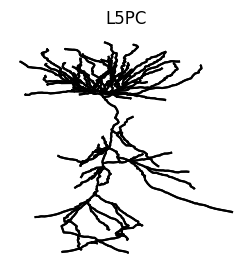

In [4]:
# visualize the cell
cell.vis()
plt.axis("off")
plt.title("L5PC")
plt.show()

While we only use two compartments to approximate each branch in this example, we can see the morphology is still plotted in great detail. This is because we always plot the full `.swc` reconstruction irrespective of the number of compartments used. This is stored in the `cell.xyzr` attribute in a per branch fashion.

To highlight each branch seperately, we can iterate over them.

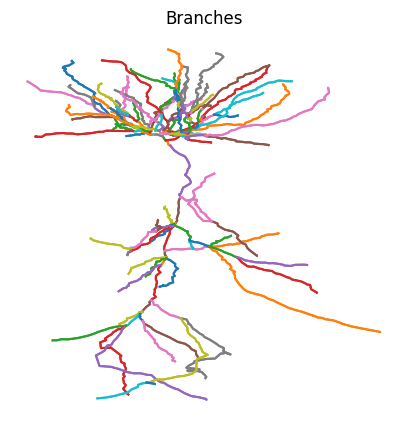

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
# define colorwheel with 10 colors
colors = plt.cm.tab10.colors
for i in range(cell.shape[1]):
    cell.branch(i).vis(ax=ax, col=colors[i % 10])
plt.axis("off")
plt.title("Branches")
plt.show()

Since `Jaxley` supports grouping different branches or compartments together, we can also use the `id` labels provided by the `.swc` file to assign group labels to the `jx.Cell` object.

['soma', 'basal', 'apical', 'custom']


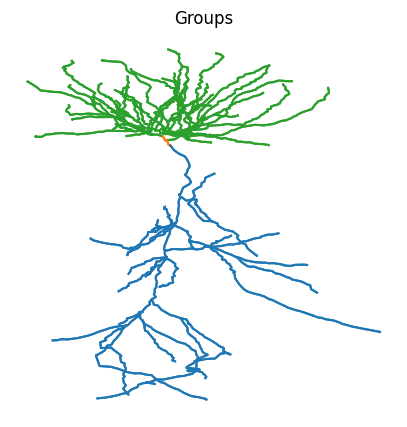

In [6]:
print(list(cell.group_nodes.keys()))


fig, ax = plt.subplots(1, 1, figsize=(5, 5))
colors = plt.cm.tab10.colors
cell.basal.vis(ax=ax, col=colors[2])
cell.soma.vis(ax=ax, col=colors[1])
cell.apical.vis(ax=ax, col=colors[0])
plt.axis("off")
plt.title("Groups")
plt.show()

To build a network of morphologically detailed cells, we can now connect several reconstructed cells together and also visualize the network. However, since all cells are going to have the same center, `Jaxley` will naively plot all of them on top of each other. To seperate out the cells, we therefore have to move them to a new location first.

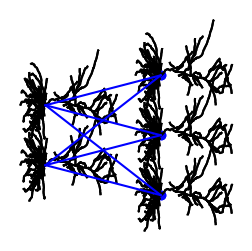

In [7]:
net = jx.Network([cell]*5)
jx.connect(net[0,0,0], net[2,0,0], IonotropicSynapse())
jx.connect(net[0,0,0], net[3,0,0], IonotropicSynapse())
jx.connect(net[0,0,0], net[4,0,0], IonotropicSynapse())

jx.connect(net[1,0,0], net[2,0,0], IonotropicSynapse())
jx.connect(net[1,0,0], net[3,0,0], IonotropicSynapse())
jx.connect(net[1,0,0], net[4,0,0], IonotropicSynapse())

net.rotate(-90)

net.cell(0).move(0, 300)
net.cell(1).move(0, 500)

net.cell(2).move(900, 200)
net.cell(3).move(900, 400)
net.cell(4).move(900, 600)

net.vis()
plt.axis("off")
plt.show()

Congrats! You have now learned how to vizualize and build networks out of very complex morphologies. To simulate this network, you can follow the steps in the tutroial on [How to build a network](02_small_network.ipynb).

## Working with graphs

While `swc` is a great way to save, load and specify complex morphologies, often more flexibility is needed. In these cases graphs present a natural way to represent and work with neural morphologies, allowing for easy fixing, pruning, smoothing and traversal of neural morphologies on the fly. For this purpose `Jaxley` also comes with a seperate `networkX` toolset, that allows for easy interoperability between `networkX` graphs and `Jaxley` Modules.

To demonstrate this, let's first define a simple morphology via a networkX graph.

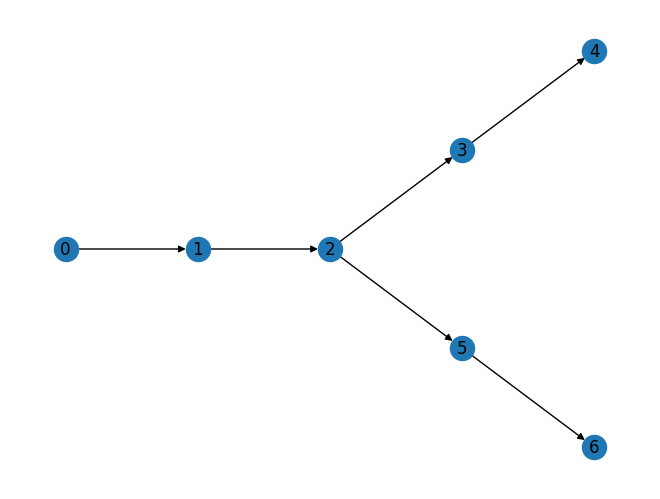

In [8]:
nodes = {
    0: {"id":1, "x": -1, "y": 0, "z": 0, "r": 2.0},
    1: {"id":1, "x": 0, "y": 0, "z": 0, "r": 2.0},
    2: {"id":1, "x": 1, "y": 0, "z": 0, "r": 2.0},
    3: {"id":1, "x": 2, "y": 1, "z": 0, "r": 1.0},
    4: {"id":1, "x": 3, "y": 2, "z": 0, "r": 1.0},
    5: {"id":1, "x": 2, "y": -1, "z": 0, "r": 1.0},
    6: {"id":1, "x": 3, "y": -2, "z": 0, "r": 1.0},
} 
edges = ((0, 1),(1, 2),(2, 3),(3, 4),(2, 5),(5, 6))

g = nx.DiGraph()
g.add_nodes_from(nodes.items())
g.add_edges_from(edges, l=1)

# Setting any of these attributes is optional. It is sufficient to define the 
# connectivity and simply do g = nx.DiGraph(edges). In this case, r and l will 
# be set to default values and x, y, z can be computed using Cell.compute_xyz().

nx.draw(g, pos={k: (v["x"], v["y"]) for k, v in nodes.items()}, with_labels=True)

The above graph can now be treated like a traced morphological reconsruction. This means we can use `io.graph` to import it into a `jx.Module` using the `from_graph` method.

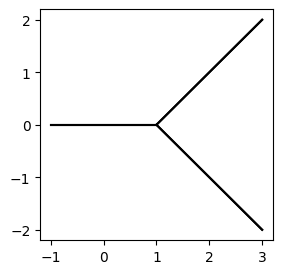

In [9]:
cell = from_graph(g, nseg=2)

cell.vis()
plt.show()

To work with more complex morphologies `io.graph` also provides a way to import `swc` reconstructions as graphs. This means we can easily view the entire tracing of the morphology. At this stage the `networkX` graph could also easily be fixed, pruned or smoothed to improve the simulation. 

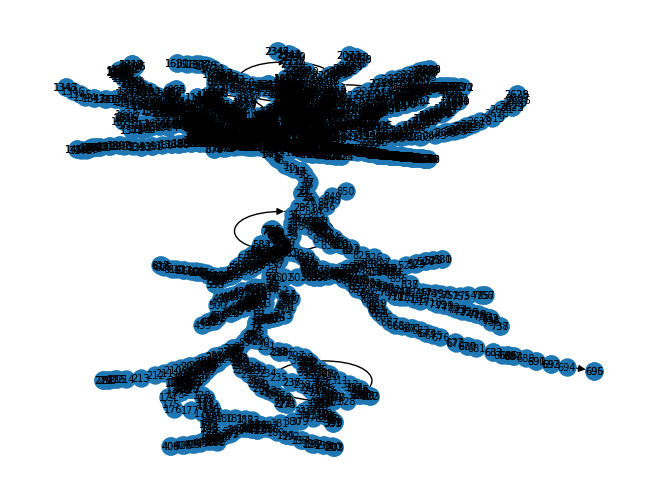

In [10]:
fname = "data/morph.swc"
graph = swc_to_graph(fname)

pos = {k: (v["x"], v["y"]) for k, v in graph.nodes.items()}
nx.draw(graph, pos=pos, with_labels=True, font_size=7, node_size=150)

To make the traced and possibly edited morphology we now need to segment it into branches and then divide the branches up into compartments. This can be done via the `io.graph.make_jaxley_compatible`, which preserves the `networkX` graph, but adds additional attributes that `Jaxley` requires to simulate it. 

node attributes {'x': 0.0, 'y': 0.0, 'z': 0.0, 'radius': 8.119000434875488, 'length': 0.00125, 'comp_index': 0, 'branch_index': 0, 'cell_index': 0, 'groups': ['soma']}
edge attributes {'type': 'intra_branch'}


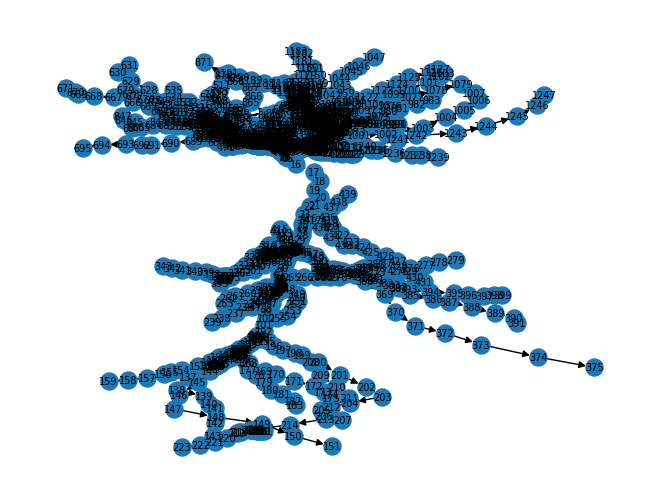

In [11]:
graph = make_jaxley_compatible(graph)

print(f"node attributes {graph.nodes[0]}")
print(f"edge attributes {graph.edges[(0, 1)]}")

pos = {k: (v["x"], v["y"]) for k, v in graph.nodes.items()}
nx.draw(graph, pos=pos, with_labels=True, font_size=7, node_size=150)

Again we can use the `from_graph` function to convert the graph into a `Cell` object, which `Jaxley` can then simulate or optimize. 

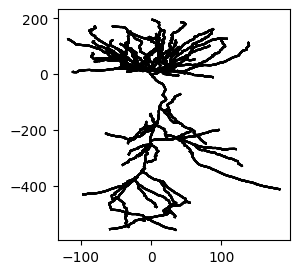

In [24]:
cell = from_graph(graph, nseg=2)

# add mechanism to cell
cell.insert(HH())

# randomize parameters, pretending the cell has been optimized
num_comps = cell.nodes.shape[0]
cell.branch("all").comp("all").set("HH_gNa", np.random.uniform(0.5, 80, num_comps))
cell.branch("all").comp("all").set("HH_gK", np.random.uniform(0.001, 30, num_comps))
cell.branch("all").comp("all").set("HH_gLeak", np.random.uniform(0.001, 0.8, num_comps))

cell.vis()
plt.show()

To close the loop `Jaxley` also offers the option to export any `Module` to a `networkX` graph object.

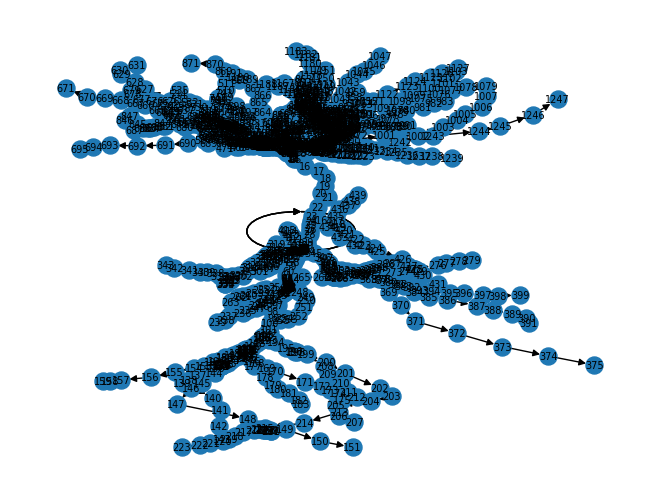

In [25]:
graph = to_graph(cell)

pos = {k: (v["x"], v["y"]) for k, v in graph.nodes.items()}
nx.draw(graph, pos=pos, with_labels=True, font_size=7, node_size=150)

This offers another way to store or share the current Module state, since `to_graph` attaches all relevant attributes to the nodes and eges of the graph. It can also be used to make more complex visualizations, using any of these attributes i.e. channel densities very easily.

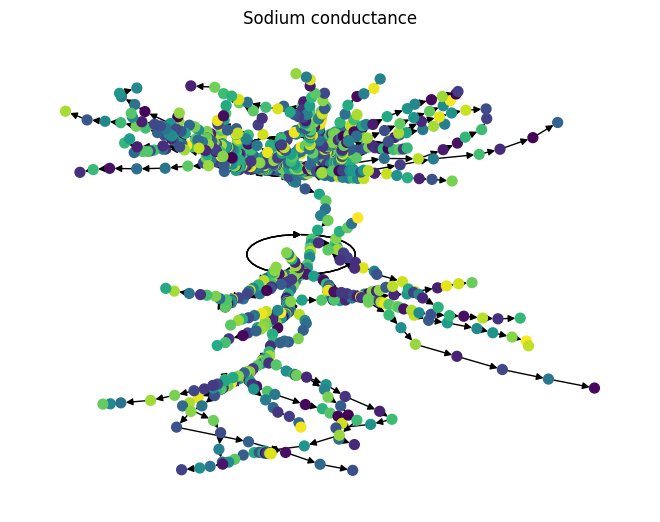

In [32]:
# plot of the cell, coloring each node according to the sodium conductance
nx.draw(graph, pos=pos, node_color=[graph.nodes[n]["HH_gNa"] for n in graph.nodes], cmap="viridis", with_labels=False, node_size=50)
plt.title("Sodium conductance")
plt.show()